In [1]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy.external as sce
from scipy.sparse import vstack

/usr/local/lib/python3.6/dist-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
adata = sc.read("../../output/adata_anno_2.h5ad")

In [13]:
adata.layers['spliced'] = adata.layers['spliced'].toarray()

In [14]:
adata.layers['unspliced'] = adata.layers['unspliced'].toarray()

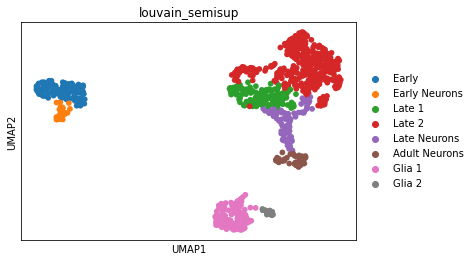

In [15]:
sc.pl.umap(adata, color = "louvain_semisup")

In [6]:
autonomic = scv.read("../../data/autonomic.loom", sparse=True, cache=True)
scv.settings.set_figure_params('scvelo')
scv.utils.show_proportions(autonomic)
scv.utils.cleanup(autonomic, clean='all')
autonomic.X = autonomic.X.astype('float64') 
autonomic.X = autonomic.X.toarray()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.79 0.11 0.1 ]


In [7]:
autonomic.layers["spliced"] = autonomic.layers["spliced"].toarray()
autonomic.layers["unspliced"] = autonomic.layers["unspliced"].toarray()
#autonomic.layers["ambiguous"] = autonomic.layers["ambiguous"].toarray()

In [9]:
#add ensembl IDs (extracted from loomfile in R)
gene_mapping = pd.read_csv("../../data/gene_mapping.csv")
autonomic.var['accession'] = list(gene_mapping['accession'])

#make gene names unique
autonomic.var_names_make_unique()

In [19]:
#add information on counts, number of genes and fraction mitochondrial
#genes for quality control

autonomic.obs['n_counts'] = autonomic.X.sum(1)
autonomic.obs['log_counts'] = np.log(autonomic.obs['n_counts'])
autonomic.obs['n_genes'] = (autonomic.X > 0).sum(1)

mt_genes_mask = [gene.startswith('mt-') for gene in autonomic.var_names]
autonomic.obs['mt_frac'] = np.sum(autonomic[:,mt_genes_mask].X, axis=1) / np.sum(autonomic.X, axis=1)

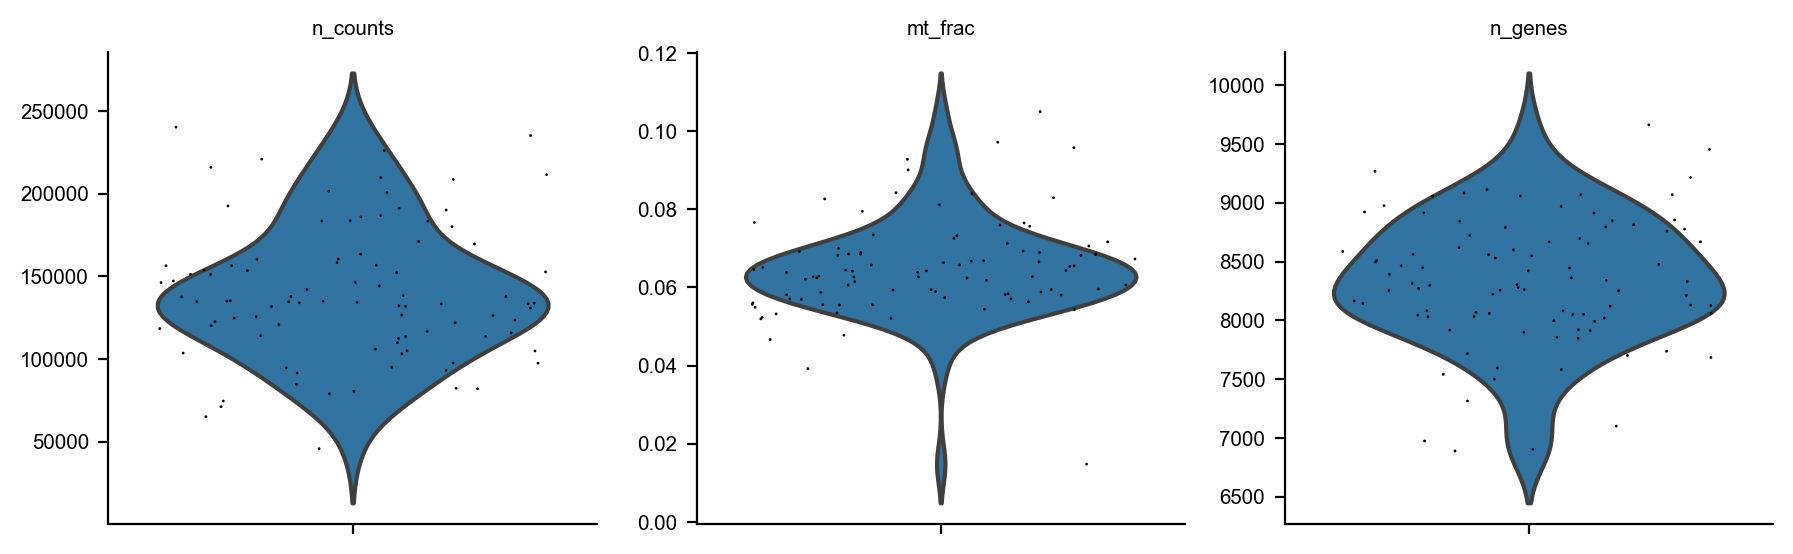

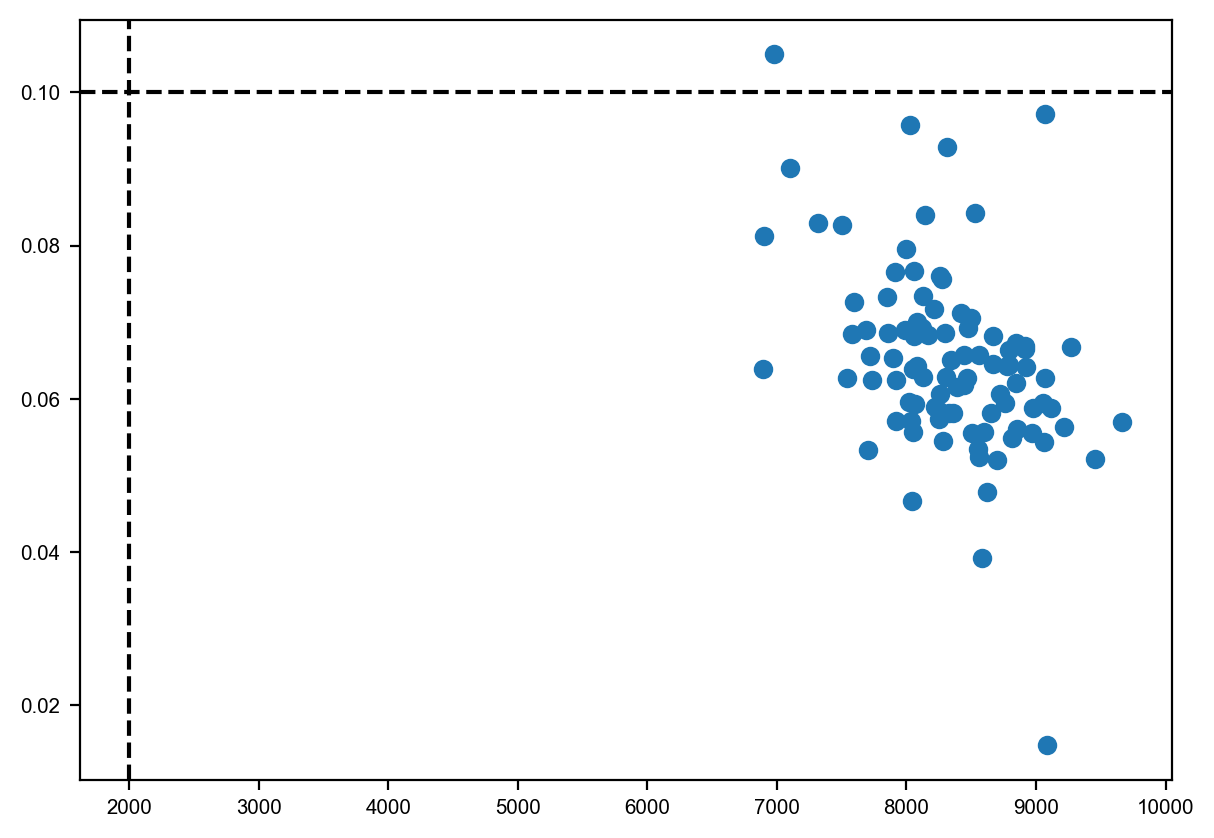

In [20]:
#visualise quality control metrics

sc.pl.violin(autonomic, ['n_counts', 'mt_frac','n_genes'],
             jitter=0.4, multi_panel=True)
fig, ax = plt.subplots()
plt.scatter(autonomic.obs['n_genes'],autonomic.obs['mt_frac'])
ax.axhline(0.1,color='black',ls='--')
ax.axvline(2000,color='black',ls='--')

In [21]:
#add raw count information to adata

autonomic.layers["counts"] = autonomic.X.copy()

In [22]:
#normalize and take log counts

sc.pp.normalize_per_cell(autonomic, counts_per_cell_after=1e6)
sc.pp.log1p(autonomic)

In [25]:
combined = adata.concatenate(autonomic, batch_key = "type")

In [28]:
factor_loadings = adata.varm["PCs"]

In [29]:
combined.varm["PCs"] = adata.varm["PCs"]

In [30]:
#project neural crest onto precomputed PCA
combined.obsm["X_pca"] = combined.X.dot(combined.varm["PCs"])

In [107]:
clusters = adata.obs

... storing '__is_in_cluster__' as categorical
... storing 'batch' as categorical
... storing 'batch_E12' as categorical
... storing 'batch_E16' as categorical
... storing 'batch_P00' as categorical
... storing 'batch_P60' as categorical
... storing 'cell_num' as categorical
... storing 'louvain_r0.5' as categorical
... storing 'louvain_r0.8' as categorical
... storing 'louvain_r1' as categorical
... storing 'louvain_r1.2' as categorical
... storing 'louvain_r1.5' as categorical
... storing 'louvain_semisup' as categorical
... storing 'phase' as categorical
... storing 'time_point' as categorical


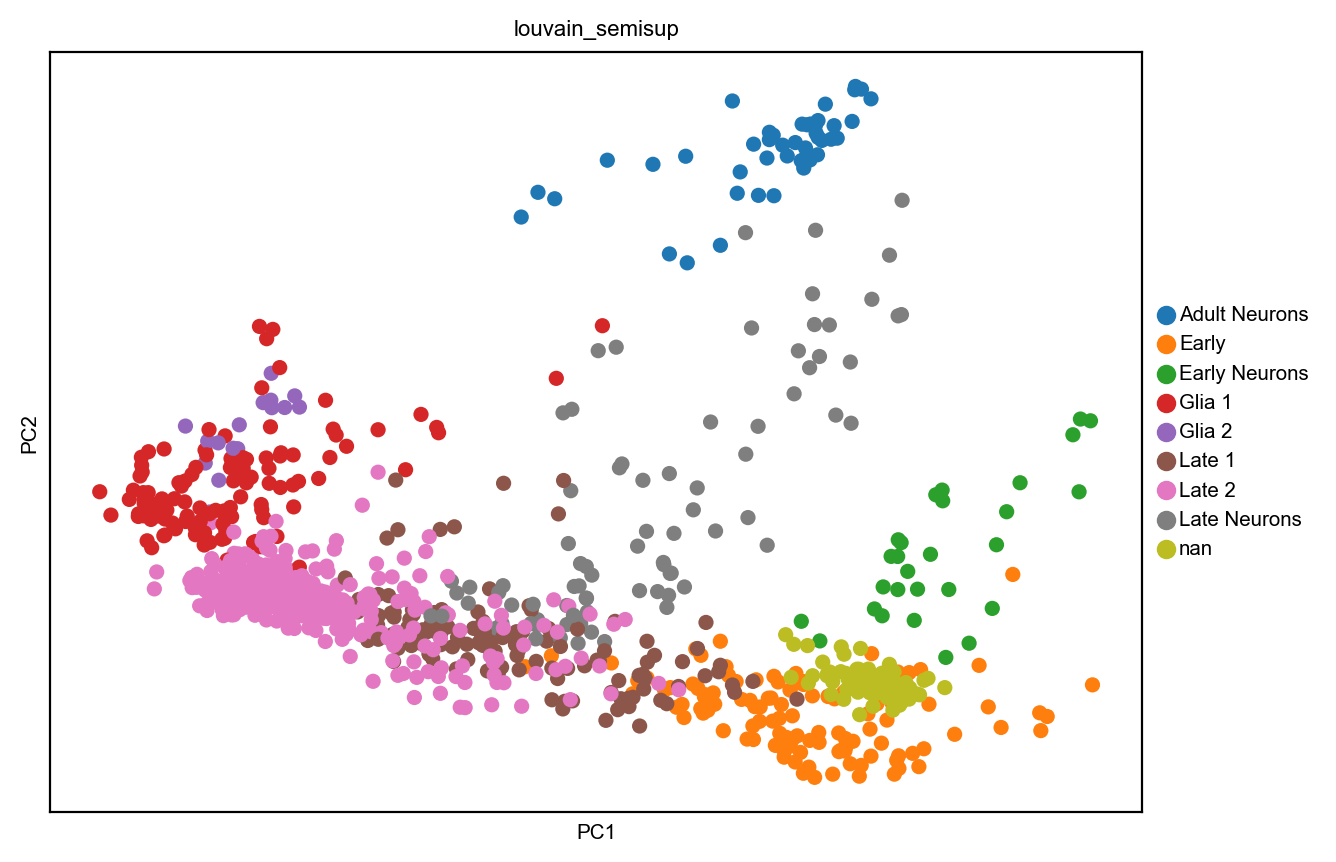

In [34]:
sc.pl.pca(combined, color = "louvain_semisup")

In [290]:
#save adata to file
combined.write("../../output/combined_anno_loom.h5ad")

data_mat = combined.X.T

dat = pd.DataFrame(data_mat)
dat.index = combined.var_names
dat.columns = combined.obs_names

dat.to_csv("../../output/combined_anno_loom.csv")
combined.obs.to_csv("../../output/combined_obs_anno_loom.csv")
combined.var.to_csv("../../output/combined_var_anno_loom.csv")


In [ ]:
combined = sc.read("../../output/combined_anno_loom.h5ad")

In [35]:
combined.var["highly_variable"] = combined.var["highly_variable-0"]

In [36]:
#recalculate PCA over autonomic and small intestine data
sc.tl.pca(combined)

In [37]:
set(combined.obs["louvain_semisup"])

{'Adult Neurons',
 'Early',
 'Early Neurons',
 'Glia 1',
 'Glia 2',
 'Late 1',
 'Late 2',
 'Late Neurons',
 'nan'}

In [38]:
combined.obs['louvain_semisup'] = pd.Categorical(combined.obs['louvain_semisup'], 
                     categories=["Autonomic","Early", "Early Neurons", "Late 1", "Late 2", "Late Neurons","Adult Neurons","Glia 1", "Glia 2"],
                    ordered=True)

In [39]:
combined.obs["louvain_semisup"][combined.obs["louvain_semisup"].isna()] = "Autonomic"

In [40]:
combined.obs['louvain_semisup'] = pd.Categorical(combined.obs['louvain_semisup'], 
                     categories=["Autonomic","Early", "Early Neurons", "Late 1", "Late 2", "Late Neurons","Adult Neurons","Glia 1", "Glia 2"],
                    ordered=True)
new_cluster_names = ["Autonomic","eEP", "eENP", "lEP1", "lEP2", "lENP","ENC","EGC1", "EGC2"]
combined.rename_categories('louvain_semisup', new_cluster_names)

In [41]:
set(combined.obs['louvain_semisup'])

{'Autonomic', 'EGC1', 'EGC2', 'ENC', 'eENP', 'eEP', 'lENP', 'lEP1', 'lEP2'}

In [42]:
#save adata to file
combined.write("../../output/combined_anno_loom.h5ad")

data_mat = combined.X.T

dat = pd.DataFrame(data_mat)
dat.index = combined.var_names
dat.columns = combined.obs_names

dat.to_csv("../../output/combined_anno_loom.csv")
combined.obs.to_csv("../../output/combined_obs_anno_loom.csv")
combined.var.to_csv("../../output/combined_var_anno_loom.csv")


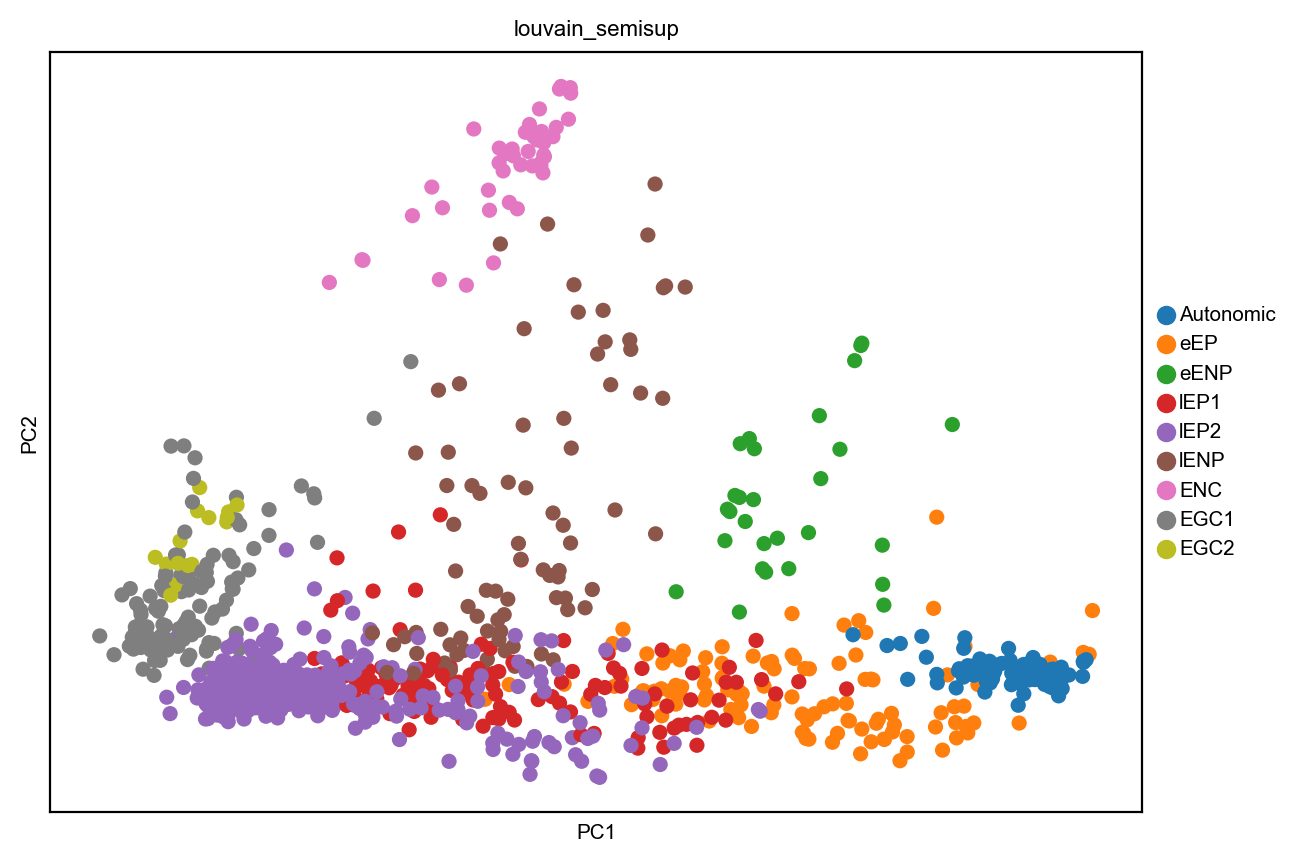

In [44]:
sc.pl.pca(combined, color = "louvain_semisup")

In [25]:
#save counts to file
data_mat = combined.layers["counts"].T

dat = pd.DataFrame(data_mat)
dat.index = combined.var_names
dat.columns = combined.obs_names

dat.to_csv("../../output/combined_anno_counts_loom.csv")

In [45]:
combined.uns['louvain_semisup_colors'] = ['#bcbd22'] +  adata.uns['louvain_semisup_colors']

In [46]:
combined.obsm["X_pca"][:,0] = -combined.obsm["X_pca"][:,0]

In [47]:
#set plotting parameters
plt.rcParams['figure.figsize']=(8,6)
plt.rcParams['font.sans-serif'] = "Helvetica"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['legend.fontsize'] = 16

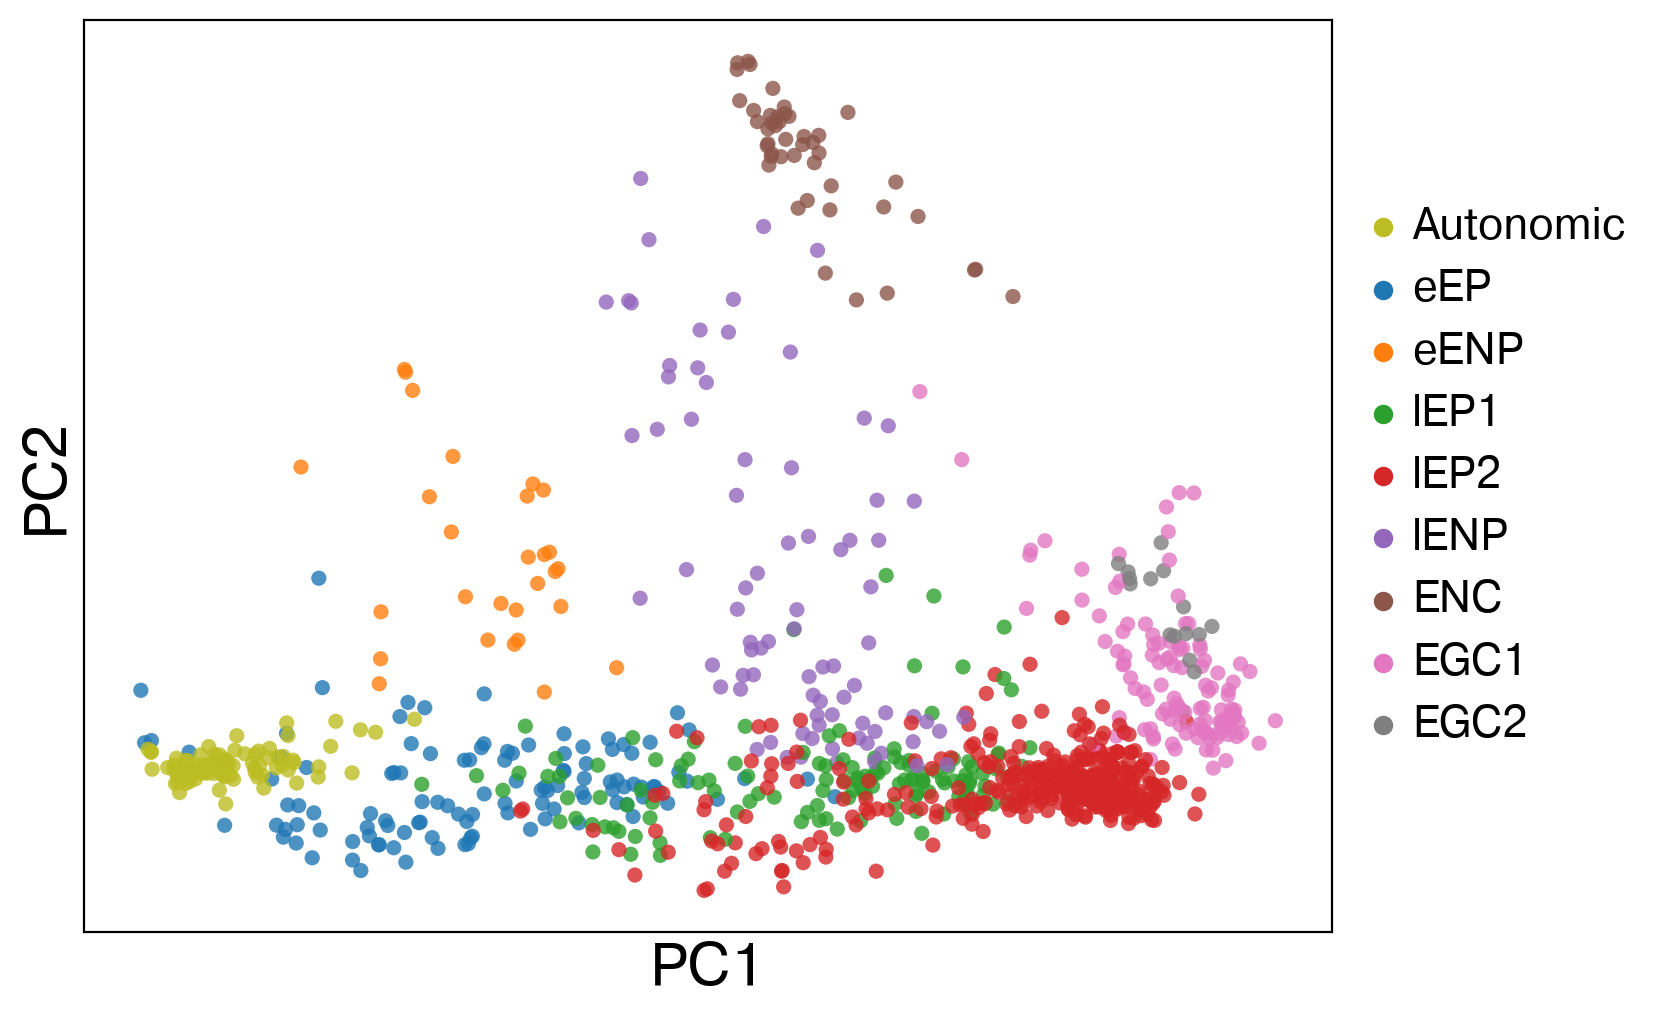

In [289]:
sc.pl.pca(combined,frameon = True, title = "", legend_fontweight = "bold", color = "louvain_semisup", alpha = 0.8, components = ["1,2"], save = "SI_autonomic.png")

In [49]:
combined.write("../../output/combined_anno_loom.h5ad")